**Project implementation process**

**1. Data cleaning:**
1. For all orders with Missing arrival date, mark them first and then delete them from the modeling data.
2. Ordered Quantity is 0: Consider it as an invalid order, mark it first, and then delete it from the modeling data. Applicable to both companies (there is no NaN in Ordered Quantity.)
3. Delivered Quantity is NaN: Consider it as an undelivered order, mark it first, and study it separately.
4. Holiday and Weekend: Mark them.
5. Date anomalies (extreme years): Consider it as an erroneous order, mark it first, and then delete it from the modeling data.

**2. Data Labeling:**

Add a column Comment to the table, and use the function add_comment_column to mark various anomalies for visualization, tracking and later analysis.

**3. Visualization of data:**
1. Company A and Company B: Check the missing NaN and the 0 values.
2. Special Orders Distribution: Mark undelivered orders (Delivered Quantity NaN), invalid orders (Ordered Quantity 0 or NaN) and valid orders.
3. Visualize the distribution of delivery delays, and the proportion of abnormal dates.
4. Supplier analysis: Analyze the supplier's delivery delay rate and on-time rate (early delivery is not acceptable), and identify high risk and optimal suppliers according to the company's inventory capacity.

**4. Feature and label engineering:**
1. Delivery status definition: (Early, On-time, Late) See days_diff, the threshold is set to 1 day.
2. Quantity accuracy feature: calculate the percentage deviation of the delivery quantity (qty_deviation).
3. Weekend and holiday features
4. Feature selection: Supplier and Product Article Number


*   Supplier: (supplier feature)
Frequency encoding (frequency encoding): supplier's past order volume
Target mean encoding (target encoding): supplier's historical delivery delay rate or quantity accuracy average deviation
*   Product Article Number: (material feature)
Material number prefix: extract material category information (the first few digits as category)
Material level historical performance: material historical delay rate, quality grade distribution (only company A)
Represents "specific materials" with clear historical delivery performance characteristics.

If Product Article Number is missing, use Ordered Product for text matching and try to find the corresponding Product Article Number.
Theoretically, each standardized Product Article Number corresponds to a unique Ordered Product.
5. Quality grade coding (unique to Company A)

**5. Model selection and construction:**

*Baseline model:* Logistic regression or simple rules.

*Main models:*
1. Random Forest Classifier
2. LightGBM (good at category features)
3. XGBoost
4. CatBoost

Classification models are used for delivery status and quality grade; regression models are used to predict the degree of quantity deviation (not used yet, if you have extra time, you can try it).

**6. Model performance evaluation and analysis:**

1. Indicator selection:
Classification: F1-score (macro & weighted).
Regression: MAE, RMSE.

2. Model interpretability:
SHAP explains the impact of features on delays.
Analyze the importance of supplier, material and date features.

3. Robustness test:
Change the training sample size (such as reducing 20%, 40% of training data) to test model stability.

**7. Result report and presentation**

1. Main content:
Refined data analysis flow chart.
Feature importance ranking.
Detailed record of abnormal data and future research suggestions.

2. Visualization suggestions:
Delay rate radar chart of each supplier.
Prediction performance comparison chart (actual vs. predicted).

**8. Additional research value:**
1. Supplier risk profile:
Supplier scoring system based on on-time rate (delay rate and early arrival rate) helps companies optimize supplier selection.
2. Inventory management optimization simulation:
Based on delivery forecasts, simulate the effects of inventory strategies and emergency replenishment plans.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import holidays
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, roc_auc_score, classification_report, f1_score, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [ ]:
# Importing Data
BASE_PATH = '/content/drive/MyDrive/Anonymized'
A_FILE = f'{BASE_PATH}/Procurement_Data_Company_A_anonymized.csv'
B_FILE = f'{BASE_PATH}/Procurement_Data_Company_B_anonymized.csv'

df_a = pd.read_csv(A_FILE, sep=';', encoding='utf-8')
df_b = pd.read_csv(B_FILE, sep=';', encoding='utf-8')

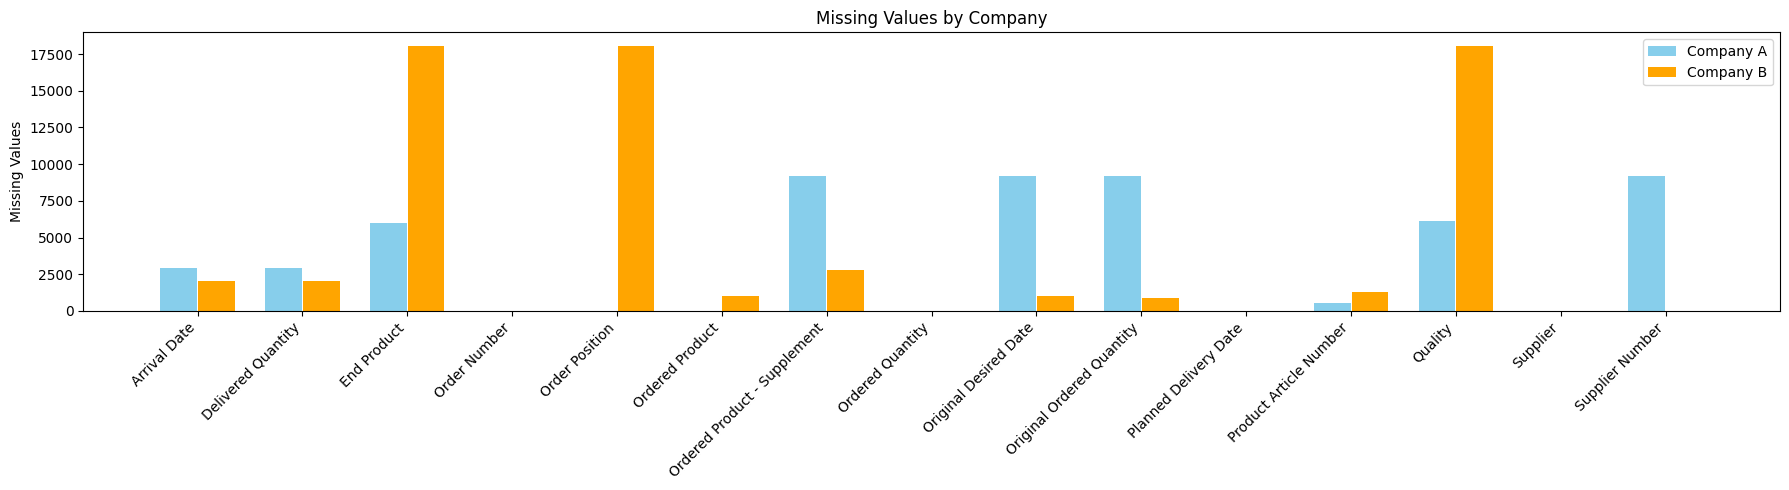

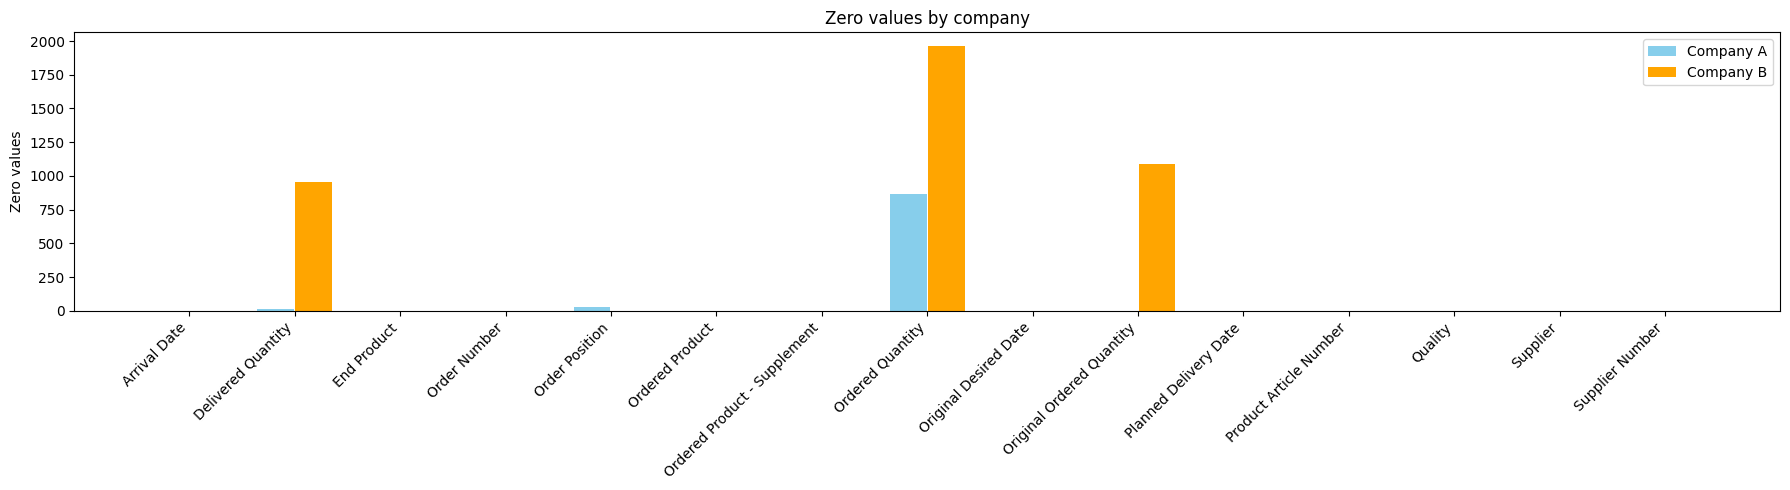

In [ ]:
# Visualization 1: Check the missing rate and 0 value ratio of two companies
def compare_missing_zero_counts(df_a, df_b):
    # Get all fields
    all_cols = sorted(list(set(df_a.columns).union(set(df_b.columns))))

    # Align fields, fill missing values with NaN/0
    nan_counts_a = df_a.reindex(columns=all_cols).isna().sum()
    nan_counts_b = df_b.reindex(columns=all_cols).isna().sum()
    zero_counts_a = df_a.reindex(columns=all_cols).eq(0).sum()
    zero_counts_b = df_b.reindex(columns=all_cols).eq(0).sum()

    x = np.arange(len(all_cols))  # Position of each field

    # 1. Missing value graph
    plt.figure(figsize=(min(18, 1.2*len(all_cols)), 5))
    plt.bar(x-0.18, nan_counts_a, width=0.35, label='Company A', color='skyblue')
    plt.bar(x+0.18, nan_counts_b, width=0.35, label='Company B', color='orange')
    plt.xticks(x, all_cols, rotation=45, ha='right')
    plt.ylabel('Missing Values')
    plt.title('Missing Values by Company')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Zero value graph
    plt.figure(figsize=(min(18, 1.2*len(all_cols)), 5))
    plt.bar(x-0.18, zero_counts_a, width=0.35, label='Company A', color='skyblue')
    plt.bar(x+0.18, zero_counts_b, width=0.35, label='Company B', color='orange')
    plt.xticks(x, all_cols, rotation=45, ha='right')
    plt.ylabel('Zero values')
    plt.title('Zero values by company')
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_missing_zero_counts(df_a, df_b)

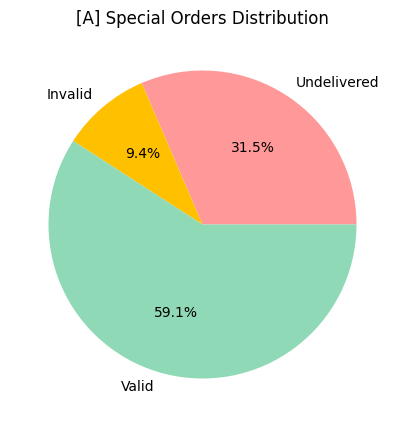

[A] Number of undelivered orders: 2893 | Number of invalid orders: 865 | Total number of orders: 9194


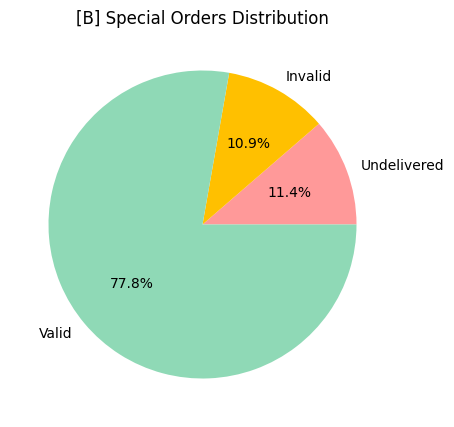

[B] Number of undelivered orders: 2052 | Number of invalid orders: 1966 | Total number of orders: 18078


In [ ]:
# Visualization 2: Special Orders Distribution
def plot_special_orders(df, company='A'):
    # Undelivered orders
    undelivered = df['Delivered Quantity'].isna()
    # Invalid orders
    invalid = df['Ordered Quantity'].isna() | (df['Ordered Quantity'] == 0)
    # Statistical quantity
    counts = {
        'Undelivered': undelivered.sum(),
        'Invalid': invalid.sum(),
        'Total': len(df)
    }
    # Pie Plot
    plt.figure(figsize=(5,5))
    plt.pie(
        [counts['Undelivered'], counts['Invalid'], counts['Total']-counts['Undelivered']-counts['Invalid']],
        labels=['Undelivered', 'Invalid', 'Valid'],
        autopct='%1.1f%%',
        colors=['#ff9999','#ffc000','#8fd9b6']
    )
    plt.title(f"[{company}] Special Orders Distribution")
    plt.show()
    print(f"[{company}] Number of undelivered orders: {counts['Undelivered']} | Number of invalid orders: {counts['Invalid']} | Total number of orders: {counts['Total']}")

plot_special_orders(df_a, 'A')
plot_special_orders(df_b, 'B')


In [ ]:
# ========== 1. Data cleaning and anomaly marking ==========
def clean_data(df, company='A'):
    df = df.copy()
    # Date processing
    for col in ['Planned Delivery Date', 'Arrival Date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    # Generate day difference
    df['days_diff'] = (df['Arrival Date'] - df['Planned Delivery Date']).dt.days

    # Generate Quantity deviation
    df['qty_diff'] = df['Delivered Quantity'] - df['Ordered Quantity']

    # Quantity deviation rate, compatible with 0 and NaN
    df['qty_deviation'] = (
        df['Delivered Quantity'].replace(0, np.nan) - df['Ordered Quantity'].replace(0, np.nan)
    ) / df['Ordered Quantity'].replace(0, np.nan)

    # Missing arrival date
    df['is_open_order'] = df['Arrival Date'].isna().astype(int)

    # Missing quantity，Only the case where Ordered Quantity = 0 or empty is considered as invalid order type
    # (the rest are kept to prove the reliability of the supplier)
    df['is_invalid'] = (df['Ordered Quantity'].isna() | (df['Ordered Quantity'] <= 0)).astype(int)

    # Holiday/weekend marking
    de_holidays = holidays.CountryHoliday('DE', years=range(2017, 2028))
    df['is_weekend'] = df['Planned Delivery Date'].dt.weekday >= 5
    df['is_holiday'] = df['Planned Delivery Date'].isin(de_holidays)

    # Extreme date (extremely early/extremely late)
    min_year, max_year = 2017, 2027
    mask_extreme = (df['Planned Delivery Date'].dt.year < min_year) | (df['Planned Delivery Date'].dt.year > max_year)
    df['is_extreme_date'] = mask_extreme.astype(int)

    # Fill in missing Quality
    if 'Quality' in df.columns:
        df['Quality'] = df['Quality'].fillna('Unknown')
    return df

df_a = clean_data(df_a, 'A')
df_b = clean_data(df_b, 'B')

In [ ]:
# Add comments and save the file
def add_comment_column(df):
    df['Comment'] = ''
    df.loc[df['is_open_order'] == 1, 'Comment'] += 'Disappearing Order; '
    df.loc[df['is_invalid'] == 1, 'Comment'] += 'Invalid Order; '
    df.loc[df['is_weekend'] == 1, 'Comment'] += 'Weekend; '
    df.loc[df['is_holiday'] == 1, 'Comment'] += 'Holiday; '
    df.loc[df['is_extreme_date'] == 1, 'Comment'] += 'Extreme Date Anomalies; '
    return df

df_a = add_comment_column(df_a)
df_b = add_comment_column(df_b)

# Save the complete annotation file (for data anomaly type tracing)
df_a.to_csv('Preprocessed_Data_A_with_Comment.csv', index=False)
df_b.to_csv('Preprocessed_Data_B_with_Comment.csv', index=False)

In [ ]:
# ========== 2. Feature Engineering and Label Generation ==========
def feature_engineering(df, company='A'):
    df = df.copy()

    # Time feature
    df['planned_month'] = df['Planned Delivery Date'].dt.month
    df['planned_weekday'] = df['Planned Delivery Date'].dt.weekday

    # Supplier frequency code
    df['supplier_freq'] = df['Supplier'].map(df['Supplier'].value_counts())

    # article_prefix
    if 'Product Article Number' in df.columns:
        df['article_prefix'] = df['Product Article Number'].astype(str).str[:3]
    else:
        df['article_prefix'] = '000'
    return df

df_a = feature_engineering(df_a, 'A')
df_b = feature_engineering(df_b, 'B')

In [ ]:
# Label generation function can flexibly adjust the threshold
def assign_delivery_status(days_diff, threshold=1):
    if pd.isna(days_diff):
        return np.nan
    if days_diff < -threshold:
        return 'Early'
    elif -threshold <= days_diff <= threshold:
        return 'On-time'
    else:
        return 'Late'

for df in [df_a, df_b]:
    df['delivery_status'] = df['days_diff'].apply(lambda x: assign_delivery_status(x, threshold=1))
    df['quantity_status'] = df['qty_diff'].apply(lambda x: 'Less' if x < 0 else ('More' if x > 0 else 'Correct'))

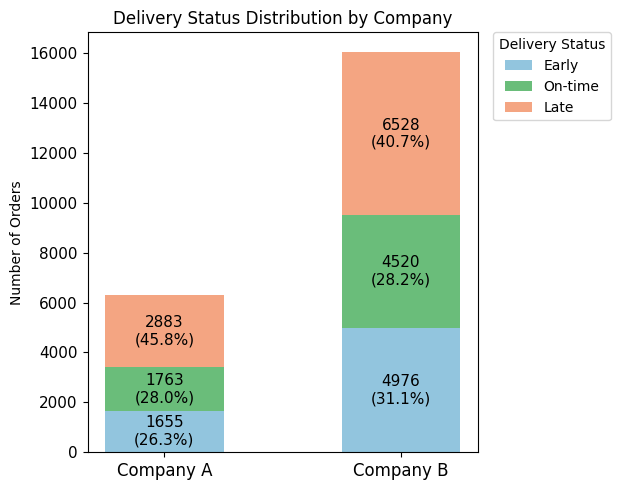

In [ ]:
# Statistical distribution (raw quantity)
status_counts_a = df_a['delivery_status'].value_counts().reindex(['Early', 'On-time', 'Late'], fill_value=0)
status_counts_b = df_b['delivery_status'].value_counts().reindex(['Early', 'On-time', 'Late'], fill_value=0)

# Merge into DataFrame for easy drawing
status_df = pd.DataFrame({
    'Company A': status_counts_a,
    'Company B': status_counts_b
}).T

# Calculate percentage
status_pct = status_df.div(status_df.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8, 5))

# Color settings: Early-blue, On-time-green, Late-orange
colors = ['#92c5de', '#6abd7a', '#f4a582']  # Early, On-time, Late
labels = ['Early', 'On-time', 'Late']

bottoms = np.zeros(len(status_df))

for i, status in enumerate(labels):
    values = status_df[status]
    ax.bar(
        status_df.index,
        values,
        bottom=bottoms,
        color=colors[i],
        label=f"{status}",
        width=0.5
    )
    # Add value and percentage labels
    for j, v in enumerate(values):
        pct = status_pct.iloc[j, i]
        ax.text(j, bottoms[j] + v / 2, f"{int(v)}\n({pct:.1f}%)", ha='center', va='center', fontsize=11, color='black')
    bottoms += values

ax.set_ylabel('Number of Orders')
ax.set_title('Delivery Status Distribution by Company')

ax.legend(title='Delivery Status', bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

[A] Percentage of abnormal dates (<2017 or >2027 or missing): 0.00%
[A] After filtering abnormal dates and outlier delays, 6269 records remain (68.19% of total)


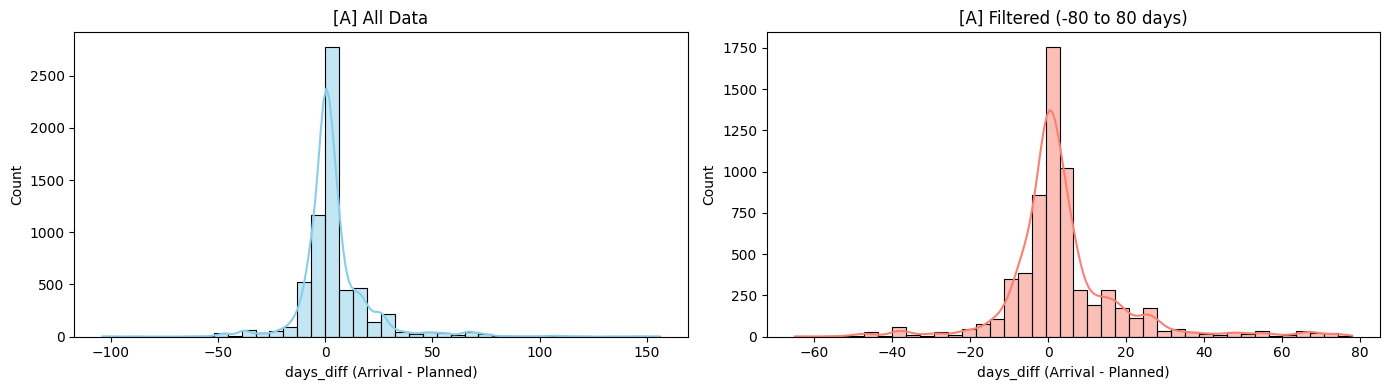

[B] Percentage of abnormal dates (<2017 or >2027 or missing): 0.63%
[B] After filtering abnormal dates and outlier delays, 15506 records remain (85.77% of total)


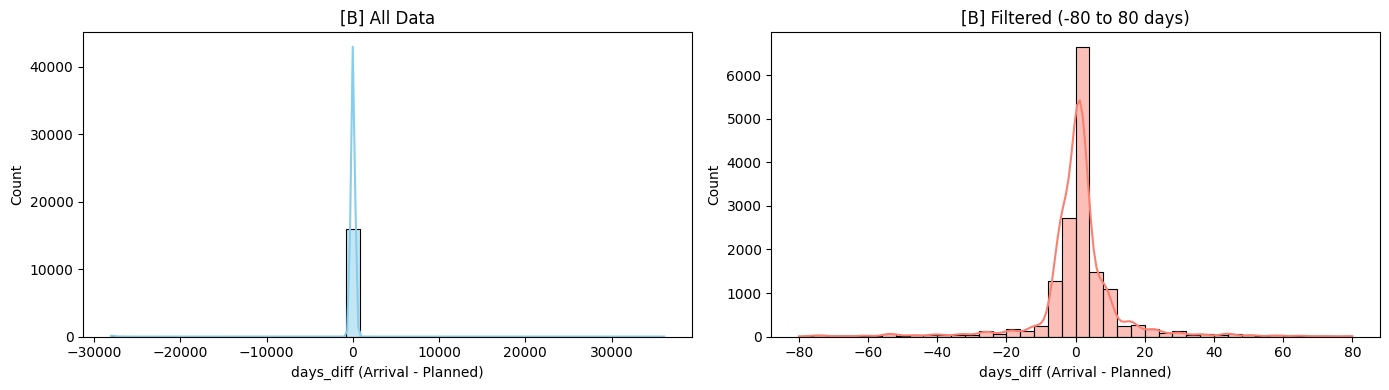

In [ ]:
# Visualization 3: The distribution of delivery delays and the proportion of abnormal dates
def delivery_delay_comparison(df, company='A', filter_range=(-80, 80)):
    df = df.copy()
    # Calculate days_diff
    if 'days_diff' not in df.columns:
        df['days_diff'] = (pd.to_datetime(df['Arrival Date']) - pd.to_datetime(df['Planned Delivery Date'])).dt.days

    # Statistical abnormal date ratio
    planned_year = pd.to_datetime(df['Planned Delivery Date'], errors='coerce').dt.year
    mask_extreme = (planned_year < 2017) | (planned_year > 2027) | (planned_year.isna())
    extreme_ratio = mask_extreme.mean()
    print(f"[{company}] Percentage of abnormal dates (<2017 or >2027 or missing): {extreme_ratio:.2%}")

    # Remove abnormal dates and extreme delays (such as days other than [-80, 80])
    df_filtered = df.loc[~mask_extreme].copy()
    df_filtered = df_filtered[df_filtered['days_diff'].between(filter_range[0], filter_range[1])]
    print(f"[{company}] After filtering abnormal dates and outlier delays, "
          f"{len(df_filtered)} records remain ({len(df_filtered)/len(df):.2%} of total)")

    # Side by side display
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(df['days_diff'].dropna(), bins=40, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"[{company}] All Data")
    axes[0].set_xlabel('days_diff (Arrival - Planned)')

    sns.histplot(df_filtered['days_diff'].dropna(), bins=40, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"[{company}] Filtered ({filter_range[0]} to {filter_range[1]} days)")
    axes[1].set_xlabel('days_diff (Arrival - Planned)')

    plt.tight_layout()
    plt.show()

delivery_delay_comparison(df_a, 'A', filter_range=(-80,80))
delivery_delay_comparison(df_b, 'B', filter_range=(-80,80))

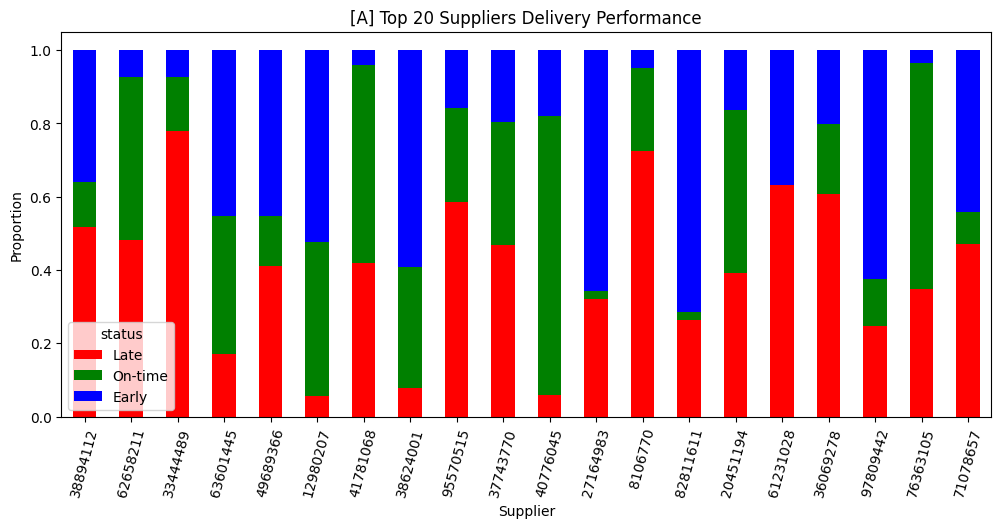


[A] High-risk suppliers (on-time rate = 0%, orders ≥ 10):
Status\Supplier 206030 3561756 3969184 11438916 22163627 33965406 34298237 43154360 48452625 50798692 54605522 59721763 61231028 63735501 69934049 70117982 77312309 82481483 89218694
        On-time   0.00    0.00    0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
           Late   0.21    1.00    1.00     1.00     1.00     1.00     1.00     0.12     1.00     1.00     0.86     1.00     0.63     0.78     0.62     0.90     1.00     0.91     1.00
   Total Orders     33      16      50       31       10       19       43       16       40       13       14       15       95       27       21       10       10       23       14

[A] Best suppliers (on-time rate = 100%, orders ≥ 10):
Status\Supplier 24520088 24970570 81887032 82330133 96608810
        On-time     1.00     1.00     1.00     1.00     1.00
           Late     0.00     0.

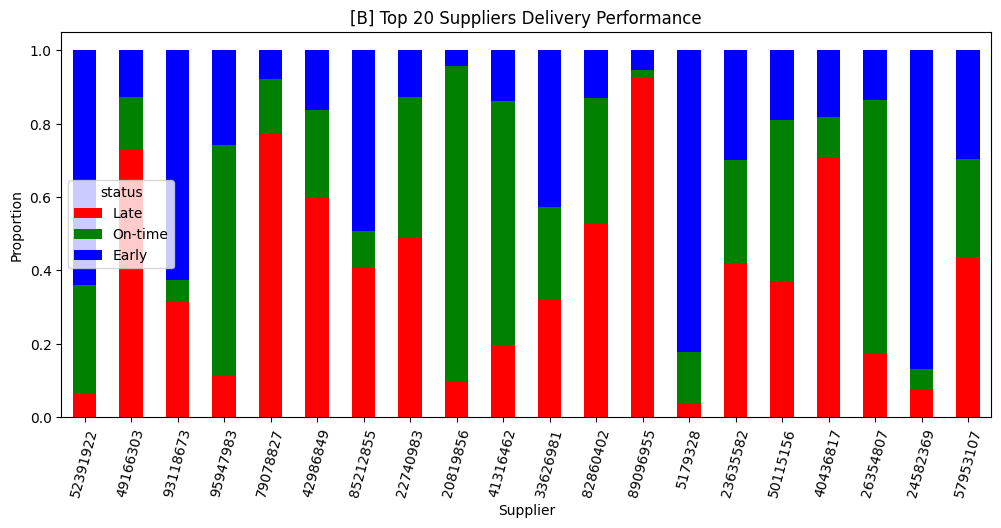


[B] High-risk suppliers (late rate = 100%, orders ≥ 10):
Status\Supplier 3095093 3533546 25454551 53428301 58980674 64623036 69653562
           Late    1.00    1.00     1.00     1.00     1.00     1.00     1.00
        On-time    0.00    0.00     0.00     0.00     0.00     0.00     0.00
   Total Orders      16      11       47       29       10       12       10

[B] Best suppliers (late rate = 0%, orders ≥ 10):
Status\Supplier 16268987 17992917 19109668 27215351 28061080 38768213 88389265 88980048
           Late     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
        On-time     0.53     0.10     0.21     0.48     0.15     1.00     0.50     0.00
   Total Orders       17       10       19       29       13       11       34       24


In [ ]:
# Visualization 4: Visualize supplier status, output high risk and optimal suppliers according to the company's inventory capacity
def supplier_performance_analysis(df, company='A'):
    df = df.copy()

    # Remove invalid or undelivered orders
    valid = df[(~df['Delivered Quantity'].isna()) & (~df['Ordered Quantity'].isna()) & (df['Ordered Quantity'] > 0)]

    # Calculate delivery delays
    valid['days_diff'] = (pd.to_datetime(valid['Arrival Date']) - pd.to_datetime(valid['Planned Delivery Date'])).dt.days

    # Define delayed/on-time/early
    threshold = 1
    valid['status'] = valid['days_diff'].apply(
        lambda x: 'Late' if x > threshold else ('Early' if x < -threshold else 'On-time')
    )

    # Supplier statistics
    supplier_stats = valid.groupby('Supplier')['status'].value_counts(normalize=True).unstack().fillna(0)
    supplier_stats['Total Orders'] = valid.groupby('Supplier').size()

    # Visualize the delay rate and on-time rate of the top 20 suppliers
    supplier_stats_top = supplier_stats.sort_values('Total Orders', ascending=False).head(20)
    color_dict = ['red', 'green', 'blue']  # Late, On-time, Early
    supplier_stats_top[['Late', 'On-time', 'Early']].plot(
        kind='bar',
        stacked=True,
        figsize=(12, 5),
        color=color_dict
    )
    plt.title(f"[{company}] Top 20 Suppliers Delivery Performance")
    plt.ylabel('Proportion')
    plt.xticks(rotation=75)
    plt.show()

    # Create and print customized summary table
    def create_summary_table(selected_suppliers, metric1, metric2, metric1_name, metric2_name):
        data = {
            'Status\\Supplier': [metric1_name, metric2_name, 'Total Orders']
        }
        for sup in selected_suppliers.index:
            data[sup] = [
                f"{selected_suppliers.loc[sup, metric1]:.2f}",
                f"{selected_suppliers.loc[sup, metric2]:.2f}" if metric2 in selected_suppliers.columns else '-',
                f"{int(selected_suppliers.loc[sup, 'Total Orders'])}"
            ]
        summary_df = pd.DataFrame(data)
        return summary_df

    # Output high risk and optimal suppliers according to the company's inventory capacity
    # Company A has no inventory capacity
    # Company A focuses on on-time rate, and Company B focuses on delay rate.

    if company.upper() == 'A':
        # High risk suppliers：On-time == 0%, Orders >= 10
        high_risk = supplier_stats[(supplier_stats['On-time'] == 0.0) & (supplier_stats['Total Orders'] >= 10)].sort_values('On-time', ascending=True)
        if not high_risk.empty:
            print(f"\n[{company}] High-risk suppliers (on-time rate = 0%, orders ≥ 10):")
            table_hr = create_summary_table(high_risk, 'On-time', 'Late', 'On-time', 'Late')
            print(table_hr.to_string(index=False))
        else:
            print(f"\n[{company}] No high-risk suppliers found (on-time rate = 0%, orders ≥ 10).")

        # Optimal suppliers：On-time == 100%, Orders >= 10
        best = supplier_stats[(supplier_stats['On-time'] == 1.0) & (supplier_stats['Total Orders'] >= 10)].sort_values('On-time', ascending=False)
        if not best.empty:
            print(f"\n[{company}] Best suppliers (on-time rate = 100%, orders ≥ 10):")
            table_best = create_summary_table(best, 'On-time', 'Late', 'On-time', 'Late')
            print(table_best.to_string(index=False))
        else:
            print(f"\n[{company}] No best suppliers found (on-time rate = 100%, orders ≥ 10).")

    elif company.upper() == 'B':
        # High risk suppliers：Late == 100%, Orders >= 10
        high_risk = supplier_stats[(supplier_stats['Late'] == 1.0) & (supplier_stats['Total Orders'] >= 10)].sort_values('Late', ascending=False)
        if not high_risk.empty:
            print(f"\n[{company}] High-risk suppliers (late rate = 100%, orders ≥ 10):")
            table_hr = create_summary_table(high_risk, 'Late', 'On-time', 'Late', 'On-time')
            print(table_hr.to_string(index=False))
        else:
            print(f"\n[{company}] No high-risk suppliers found (late rate = 100%, orders ≥ 10).")

        # Optimal suppliers：Late == 0%, Orders >= 10
        best = supplier_stats[(supplier_stats['Late'] == 0.0) & (supplier_stats['Total Orders'] >= 10)].sort_values('Late', ascending=True)
        if not best.empty:
            print(f"\n[{company}] Best suppliers (late rate = 0%, orders ≥ 10):")
            table_best = create_summary_table(best, 'Late', 'On-time', 'Late', 'On-time')
            print(table_best.to_string(index=False))
        else:
            print(f"\n[{company}] No best suppliers found (late rate = 0%, orders ≥ 10).")

    else:
        print("Unknown company type; please specify 'A' or 'B'.")

supplier_performance_analysis(df_a, 'A')
supplier_performance_analysis(df_b, 'B')

In [ ]:
# ========== 3. Data screening and training set segmentation ===========
# Keep valid samples

# When training the delivery status model, quantity_status is allowed to be missing.
def filter_train_data_for_delivery(df):
    return df[(df['is_invalid'] == 0) & (df['is_extreme_date'] == 0) & (df['is_open_order'] == 0)].dropna(subset=['delivery_status'])

# When training the quantity accuracy model, delivery_status is allowed to be missing.
def filter_train_data_for_quantity(df):
    return df[(df['is_invalid'] == 0) & (df['is_extreme_date'] == 0) & (df['is_open_order'] == 0)].dropna(subset=['quantity_status'])

# Filter data separately
train_a_delivery = filter_train_data_for_delivery(df_a)
train_b_delivery = filter_train_data_for_delivery(df_b)

train_a_quantity = filter_train_data_for_quantity(df_a)
train_b_quantity = filter_train_data_for_quantity(df_b)

In [ ]:
# ========== Feature Engineering for Delivery Status ==========
# Maintain the original feature engineering for Company A
# Add some new feature for Company B

def extended_feature_engineering_delivery(df):
    df = df.copy()
    df['supplier_delay_mean'] = df.groupby('Supplier')['days_diff'].transform('mean')
    df['supplier_late_rate'] = df.groupby('Supplier')['delivery_status'].transform(lambda x: (x == 'Late').mean())
    df['supplier_less_rate'] = df.groupby('Supplier')['quantity_status'].transform(lambda x: (x == 'Less').mean())
    df['supplier_more_rate'] = df.groupby('Supplier')['quantity_status'].transform(lambda x: (x == 'More').mean())
    df['article_prefix_freq'] = df.groupby('article_prefix')['article_prefix'].transform('count')
    # Add new features for Company B
    df['planned_quarter'] = df['planned_month'].apply(lambda x: (x-1)//3 + 1)
    df['supplier_order_count'] = df.groupby('Supplier').cumcount()+1
    df['product_order_count'] = df.groupby('Product Article Number').cumcount()+1
    df['supplier_month_ontime_rate'] = df.groupby(['Supplier', 'planned_month'])['delivery_status'].transform(lambda x: (x == 'On-time').mean())
    df['supplier_month_delay_mean'] = df.groupby(['Supplier', 'planned_month'])['days_diff'].transform('mean')
    df['product_month_delay_mean'] = df.groupby(['Product Article Number', 'planned_month'])['days_diff'].transform('mean')
    # Quality encoding (only Company A)
    if 'Quality' in df.columns:
        df['quality_encoded'] = LabelEncoder().fit_transform(df['Quality'])
    else:
        df['quality_encoded'] = np.nan
    return df

train_a_delivery = extended_feature_engineering_delivery(train_a_delivery)
train_b_delivery = extended_feature_engineering_delivery(train_b_delivery)

features_a_delivery = [
    'Ordered Quantity', 'planned_month', 'planned_weekday', 'is_weekend', 'is_holiday',
    'Supplier', 'Product Article Number', 'supplier_freq', 'supplier_delay_mean',
    'supplier_late_rate', 'supplier_less_rate', 'supplier_more_rate',
    'article_prefix_freq', 'quality_encoded'
]
features_b_delivery = [
    'Ordered Quantity', 'planned_month', 'planned_weekday', 'is_weekend', 'is_holiday',
    'Supplier', 'Product Article Number', 'supplier_freq', 'supplier_delay_mean',
    'supplier_late_rate', 'supplier_less_rate', 'supplier_more_rate',
    'article_prefix_freq',
    # New features
    'planned_quarter', 'supplier_order_count', 'product_order_count',
    'supplier_month_ontime_rate', 'supplier_month_delay_mean', 'product_month_delay_mean'
]


# Label Encoding (Processing categorical features)
cat_cols = ['Supplier', 'Product Article Number']
def encode_categorical(df, cat_cols):
    df = df.copy()
    for col in cat_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df

train_a_delivery = encode_categorical(train_a_delivery, cat_cols)
train_b_delivery = encode_categorical(train_b_delivery, cat_cols)

X_a_delivery = train_a_delivery[features_a_delivery].fillna(0)
X_b_delivery = train_b_delivery[features_b_delivery].fillna(0)
y_a_delivery = train_a_delivery['delivery_status']
y_b_delivery = train_b_delivery['delivery_status']
le_delivery = LabelEncoder()
y_a_delivery_enc = le_delivery.fit_transform(y_a_delivery)
y_b_delivery_enc = le_delivery.transform(y_b_delivery)

In [ ]:
# ========== Feature Engineering for Delivery Status ==========  Old Version
# Maintain the original feature engineering of script V2

# def extended_feature_engineering_delivery(df):
#     df = df.copy()
#     df['supplier_delay_mean'] = df.groupby('Supplier')['days_diff'].transform('mean')
#     df['supplier_late_rate'] = df.groupby('Supplier')['delivery_status'].transform(lambda x: (x == 'Late').mean())
#     df['supplier_less_rate'] = df.groupby('Supplier')['quantity_status'].transform(lambda x: (x == 'Less').mean())
#     df['supplier_more_rate'] = df.groupby('Supplier')['quantity_status'].transform(lambda x: (x == 'More').mean())
#     df['article_prefix_freq'] = df.groupby('article_prefix')['article_prefix'].transform('count')
#     # Quality encoding (only Company A)
#     if 'Quality' in df.columns:
#         df['quality_encoded'] = LabelEncoder().fit_transform(df['Quality'])
#     else:
#         df['quality_encoded'] = np.nan # For company B
#     return df

# train_a_delivery = extended_feature_engineering_delivery(train_a_delivery)
# train_b_delivery = extended_feature_engineering_delivery(train_b_delivery)

# features_a_delivery = [
#     'Ordered Quantity', 'planned_month', 'planned_weekday', 'is_weekend', 'is_holiday',
#     'Supplier', 'Product Article Number', 'supplier_freq', 'supplier_delay_mean',
#     'supplier_late_rate', 'supplier_less_rate', 'supplier_more_rate',
#     'article_prefix_freq', 'quality_encoded'
# ]
# features_b_delivery = [
#     'Ordered Quantity', 'planned_month', 'planned_weekday', 'is_weekend', 'is_holiday',
#     'Supplier', 'Product Article Number', 'supplier_freq', 'supplier_delay_mean',
#     'supplier_late_rate', 'supplier_less_rate', 'supplier_more_rate',
#     'article_prefix_freq'
# ]

# # Label Encoding (Processing categorical features)
# cat_cols = ['Supplier', 'Product Article Number']
# def encode_categorical(df, cat_cols):
#     df = df.copy()
#     for col in cat_cols:
#         df[col] = LabelEncoder().fit_transform(df[col].astype(str))
#     return df

# train_a_delivery = encode_categorical(train_a_delivery, cat_cols)
# train_b_delivery = encode_categorical(train_b_delivery, cat_cols)

# X_a_delivery = train_a_delivery[features_a_delivery].fillna(0)
# X_b_delivery = train_b_delivery[features_b_delivery].fillna(0)
# y_a_delivery = train_a_delivery['delivery_status']
# y_b_delivery = train_b_delivery['delivery_status']
# le_delivery = LabelEncoder()
# y_a_delivery_enc = le_delivery.fit_transform(y_a_delivery)
# y_b_delivery_enc = le_delivery.transform(y_b_delivery)

Old Version Output

====== Company A - Delivery Status (5-Fold CV macro-F1) ======

Baseline (Logistic): 0.547

RandomForest: 0.875

CatBoost: 0.854

LightGBM: 0.866

XGBoost: 0.876

>> Best Model for Company A: XGBoost

======================================================================
Company A Delivery Status (XGBoost) - Classification Report

              precision    recall  f1-score   support

      Early     0.824     0.861     0.842       331
      Late      0.891     0.897     0.894       574
      On-time     0.901     0.852     0.876       352

     accuracy                      0.875      1257
     macro avg      0.872     0.870     0.871      1257
     weighted avg     0.876     0.875     0.875      1257

Accuracy: 0.875

======================================================================

====== Company B - Delivery Status (5-Fold CV macro-F1) ======

Baseline (Logistic): 0.439

RandomForest: 0.706

CatBoost: 0.675

LightGBM: 0.682

XGBoost: 0.694

>> Best Model for Company B: RandomForest

======================================================================
Company B Delivery Status (RandomForest) - Classification Report

              precision    recall  f1-score   support

     Early      0.706     0.703     0.705       940
      Late      0.733     0.777     0.754      1183
     On-time      0.696     0.643     0.669       883

     accuracy                      0.715      3006
     macro avg      0.712     0.708     0.709      3006
     weighted avg     0.714     0.715     0.714      3006

Accuracy: 0.715

======================================================================

In [ ]:
# ========== Feature Engineering for Quantity Status ==========

# Drawing on several points in the common script
# 1. Introduce aggregated statistical features (historical statistical features of suppliers/products)
# 2. OneHotEncoder encoding
# 3. SMOTE sampling

def feature_engineering_quantity(df):
    df = df.copy()
    # 1. Supplier historical average delivery difference
    supplier_qty_dev_mean = df.groupby('Supplier')['qty_diff'].transform('mean')
    df['supplier_quantity_deviation_mean'] = supplier_qty_dev_mean
    # 1. Product historical average delivery difference
    prod_qty_dev_mean = df.groupby('Product Article Number')['qty_diff'].transform('mean')
    df['product_quantity_deviation_mean'] = prod_qty_dev_mean
    return df

train_a_quantity = feature_engineering_quantity(train_a_quantity)
train_b_quantity = feature_engineering_quantity(train_b_quantity)

features_a_quantity = [
    'Ordered Quantity', 'planned_month', 'planned_weekday', 'is_weekend', 'is_holiday',
    'Supplier', 'Product Article Number', 'supplier_freq',
    'supplier_quantity_deviation_mean', 'product_quantity_deviation_mean'
]
features_b_quantity = [
    'Ordered Quantity', 'planned_month', 'planned_weekday', 'is_weekend', 'is_holiday',
    'Supplier', 'Product Article Number', 'supplier_freq',
    'supplier_quantity_deviation_mean', 'product_quantity_deviation_mean'
]

# 2. OneHotEncoder encoding (only for Quantity Status)
categorical_features = ['Supplier', 'Product Article Number']
preprocessor_a = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)
preprocessor_b = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

X_a_quantity = train_a_quantity[features_a_quantity].fillna(0)
X_b_quantity = train_b_quantity[features_b_quantity].fillna(0)
y_a_quantity = train_a_quantity['quantity_status']
y_b_quantity = train_b_quantity['quantity_status']

le_quantity = LabelEncoder()
y_a_quantity_enc = le_quantity.fit_transform(y_a_quantity)
y_b_quantity_enc = le_quantity.transform(y_b_quantity)

# 2. OneHot Encoding
X_a_quantity_enc = preprocessor_a.fit_transform(X_a_quantity)
X_b_quantity_enc = preprocessor_b.fit_transform(X_b_quantity)

# 3. Using SMOTE to oversample the training set
smote = SMOTE(random_state=42)
X_a_quantity_sm, y_a_quantity_sm = smote.fit_resample(X_a_quantity_enc, y_a_quantity_enc)
X_b_quantity_sm, y_b_quantity_sm = smote.fit_resample(X_b_quantity_enc, y_b_quantity_enc)

In [ ]:
# ========== 4. Model training and cross-validation ==========

# Define model collection
# n_estimators/iterations： 75:Quantity Status (fast operation speed) 100:Delivery Status (high accuracy)
models = {
    'Baseline (Logistic)': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, iterations=75),
    'LightGBM': LGBMClassifier(class_weight='balanced', verbose=-1, n_estimators=75, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, n_estimators=75, n_jobs=-1),
}

# # Evaluation function (Delivery Status prediction uses KFold, Quantity Status prediction uses StratifiedKFold)
# # The "Delivery Status" label has a relatively balanced distribution of categories in Company A/B.
# # Using KFold may allow the model to learn more sample features of different combinations in some folds due to "freer" splitting, and Performed slightly better.
# # If the categories are extremely unbalanced (only a few "Early" or "More"), KFold may have "a certain category as 0" in some folds,
# # Which results in insufficient model training/validation. In this case, StratifiedKFold must be used.

def evaluate_model(model, X, y_enc, stratified=True, use_smote=False):
    if stratified:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    if use_smote:
        pipe = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('clf', model)
        ])
        model = pipe
    f1_scores = cross_val_score(model, X, y_enc, cv=cv, scoring='f1_macro', n_jobs=-1)

    return np.mean(f1_scores)



def model_report(model, X, y_enc, label_encoder, title=''):
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    print('\n' + '='*70)
    print(f"{title} - Classification Report")
    print(classification_report(y_test_labels, y_pred_labels, digits=3))
    print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels):.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
    print('='*70)

def evaluate_all_models(models, X, y_enc, label_encoder, company, taskname="Delivery Status", stratified=True):
    print(f"\n====== {company} - {taskname} (5-Fold CV macro-F1) ======")
    best_model = None
    best_score = 0
    for name, model in models.items():
        f1 = evaluate_model(model, X, y_enc, stratified=stratified)
        print(f"{name}: {f1:.3f}")
        if f1 > best_score:
            best_score = f1
            best_model = (name, model)
    # Output a detailed report of the best model on the hold-out validation set
    print(f"\n>> Best Model for {company}: {best_model[0]}")
    model_report(best_model[1], X, y_enc, label_encoder, title=f"{company} {taskname} ({best_model[0]})")

In [ ]:
# The true label distribution in the original dataset (without sampling)
print(df_a['delivery_status'].value_counts())
print(df_b['delivery_status'].value_counts())

delivery_status
Late       2883
On-time    1763
Early      1655
Name: count, dtype: int64
delivery_status
Late       6528
Early      4976
On-time    4520
Name: count, dtype: int64


In [ ]:
# # ========== Evaluate the Delivery Status ==========
# After KFold cross-validation and training dataset partitioning
evaluate_all_models(models, X_a_delivery, y_a_delivery_enc, le_delivery, company="Company A", taskname="Delivery Status", stratified=False)
evaluate_all_models(models, X_b_delivery, y_b_delivery_enc, le_delivery, company="Company B", taskname="Delivery Status", stratified=False)


====== Company A - Delivery Status (5-Fold CV macro-F1) ======
Baseline (Logistic): 0.575
RandomForest: 0.874
CatBoost: 0.840
LightGBM: 0.858
XGBoost: 0.871

>> Best Model for Company A: RandomForest

Company A Delivery Status (RandomForest) - Classification Report
              precision    recall  f1-score   support

       Early      0.833     0.873     0.853       331
        Late      0.900     0.894     0.897       574
     On-time      0.885     0.855     0.870       352

    accuracy                          0.877      1257
   macro avg      0.873     0.874     0.873      1257
weighted avg      0.878     0.877     0.878      1257

Accuracy: 0.877
Confusion Matrix:
 [[289  29  13]
 [ 35 513  26]
 [ 23  28 301]]

====== Company B - Delivery Status (5-Fold CV macro-F1) ======
Baseline (Logistic): 0.787
RandomForest: 0.939
CatBoost: 0.937
LightGBM: 0.940
XGBoost: 0.939

>> Best Model for Company B: LightGBM

Company B Delivery Status (LightGBM) - Classification Report
            

In [ ]:
# The true label distribution in the original dataset (without sampling/resampling)
print(df_a['quantity_status'].value_counts())
print(df_b['quantity_status'].value_counts())

quantity_status
Correct    9131
Less         52
More         11
Name: count, dtype: int64
quantity_status
Correct    17559
Less         519
Name: count, dtype: int64


In [ ]:
# # ========== Evaluate the Quantity Status ==========
# Use post-sampling data for model training/evaluation (after SMOTE oversampling balancing)
evaluate_all_models(models, X_a_quantity_sm, y_a_quantity_sm, le_quantity, company="Company A", taskname="Quantity Accuracy", stratified=True)
evaluate_all_models(models, X_b_quantity_sm, y_b_quantity_sm, le_quantity, company="Company B", taskname="Quantity Accuracy", stratified=True)


====== Company A - Quantity Accuracy (5-Fold CV macro-F1) ======
Baseline (Logistic): 0.908
RandomForest: 0.997
CatBoost: 0.995
LightGBM: 0.998
XGBoost: 0.998

>> Best Model for Company A: LightGBM

Company A Quantity Accuracy (LightGBM) - Classification Report
              precision    recall  f1-score   support

     Correct      0.997     0.995     0.996      1244
        Less      0.998     0.998     0.998      1245
        More      0.997     0.999     0.998      1245

    accuracy                          0.997      3734
   macro avg      0.997     0.997     0.997      3734
weighted avg      0.997     0.997     0.997      3734

Accuracy: 0.997
Confusion Matrix:
 [[1238    2    4]
 [   3 1242    0]
 [   1    0 1244]]

====== Company B - Quantity Accuracy (5-Fold CV macro-F1) ======
Baseline (Logistic): 0.902
RandomForest: 0.983
CatBoost: 0.973
LightGBM: 0.980
XGBoost: 0.977

>> Best Model for Company B: RandomForest

Company B Quantity Accuracy (RandomForest) - Classification Re

In [ ]:
# ========== Save the best model ==========
# For Delivery Status
model_rf_a_delivery = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss').fit(X_a_delivery, y_a_delivery_enc)
model_rf_b_delivery = LGBMClassifier(n_estimators=100, class_weight='balanced').fit(X_b_delivery, y_b_delivery_enc)
joblib.dump(model_rf_a_delivery, '/content/drive/MyDrive/rf_a_delivery.pkl')
joblib.dump(model_rf_b_delivery, '/content/drive/MyDrive/rf_b_delivery.pkl')

# For Quantity Status
model_rf_a_quantity = LGBMClassifier(n_estimators=75, class_weight='balanced').fit(X_a_quantity_enc, y_a_quantity_enc)
model_rf_b_quantity = RandomForestClassifier(n_estimators=100, class_weight='balanced').fit(X_b_quantity_enc, y_b_quantity_enc)
joblib.dump(model_rf_a_quantity, '/content/drive/MyDrive/rf_a_quantity.pkl')
joblib.dump(model_rf_b_quantity, '/content/drive/MyDrive/rf_b_quantity.pkl')

In [ ]:
# ========== Single Order Forecast Example ==========
def predict_single_order(model, input_dict, features, label_encoder, preprocessor=None):
    input_df = pd.DataFrame([input_dict])[features].fillna(0)
    if preprocessor is not None:
        input_df = preprocessor.transform(input_df)
    pred_encoded = model.predict(input_df)[0]
    return label_encoder.inverse_transform([pred_encoded])[0]

# === 1. Example (Company A, Delivery Status) ===
example_a_delivery = X_a_delivery.iloc[0].to_dict()
pred_a_delivery = predict_single_order(
    model_rf_a_delivery, example_a_delivery, features_a_delivery, le_delivery
)
print("Company A Example Prediction (Delivery):", pred_a_delivery)

# === 2. Example (Company A, Quantity Status) ===
example_a_quantity = X_a_quantity.iloc[0].to_dict()
pred_a_quantity = predict_single_order(
    model_rf_a_quantity, example_a_quantity, features_a_quantity, le_quantity, preprocessor=preprocessor_a
)
print("Company A Example Prediction (Quantity):", pred_a_quantity)

# === 3. Example (Company B, Delivery Status) ===
example_b_delivery = X_b_delivery.iloc[0].to_dict()
pred_b_delivery = predict_single_order(
    model_rf_b_delivery, example_b_delivery, features_b_delivery, le_delivery
)
print("Company B Example Prediction (Delivery):", pred_b_delivery)

# === 4. Example (Company B, Quantity Status) ===
example_b_quantity = X_b_quantity.iloc[0].to_dict()
pred_b_quantity = predict_single_order(
    model_rf_b_quantity, example_b_quantity, features_b_quantity, le_quantity, preprocessor=preprocessor_b
)
print("Company B Example Prediction (Quantity):", pred_b_quantity)

Company A Example Prediction (Delivery): Early
Company B Example Prediction (Delivery): Late


SHAP Explanatory Analysis (Example)

In [ ]:
# ========== Load the model ==========

model_rf_a_delivery = joblib.load('/content/drive/MyDrive/rf_a_delivery.pkl')
model_rf_b_delivery = joblib.load('/content/drive/MyDrive/rf_b_delivery.pkl')
model_rf_a_quantity = joblib.load('/content/drive/MyDrive/rf_a_quantity.pkl')
model_rf_b_quantity = joblib.load('/content/drive/MyDrive/rf_b_quantity.pkl')


========== SHAP Interpretative Analysis: Company A Delivery Status ==========


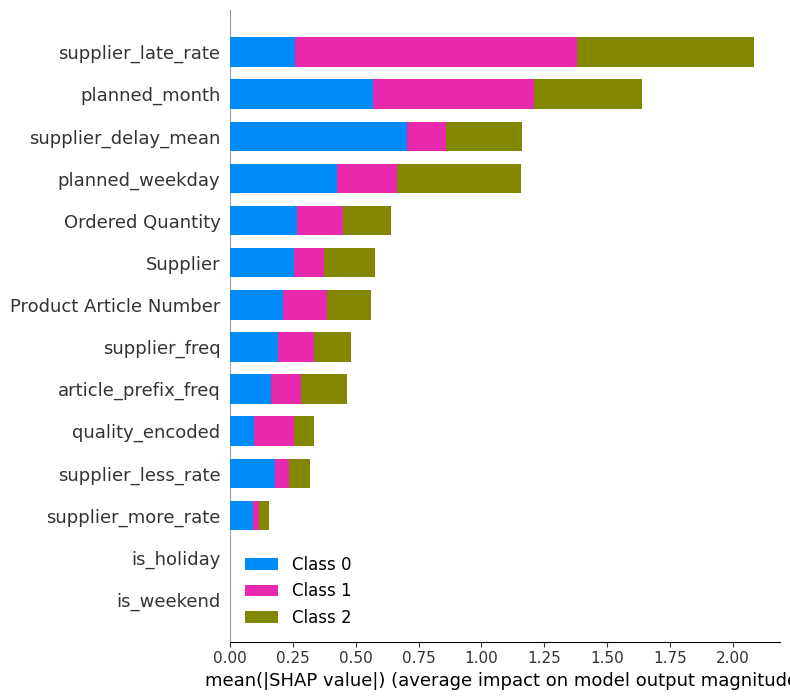

In [ ]:
# ========== SHAP Analysis: Company A Delivery Status ==========
print('\n========== SHAP Interpretative Analysis: Company A Delivery Status ==========')
explainer_a_delivery = shap.TreeExplainer(model_rf_a_delivery)
shap_values_a_delivery = explainer_a_delivery.shap_values(X_a_delivery)

shap.summary_plot(
    shap_values_a_delivery,
    X_a_delivery,
    feature_names=features_a_delivery,
    plot_type='bar',
    show=True
)
# shap.summary_plot(
#     shap_values_a_delivery,
#     X_a_delivery,
#     feature_names=features_a_delivery,
#     show=True
# )


========== SHAP Interpretative Analysis: Company B Delivery Status ==========


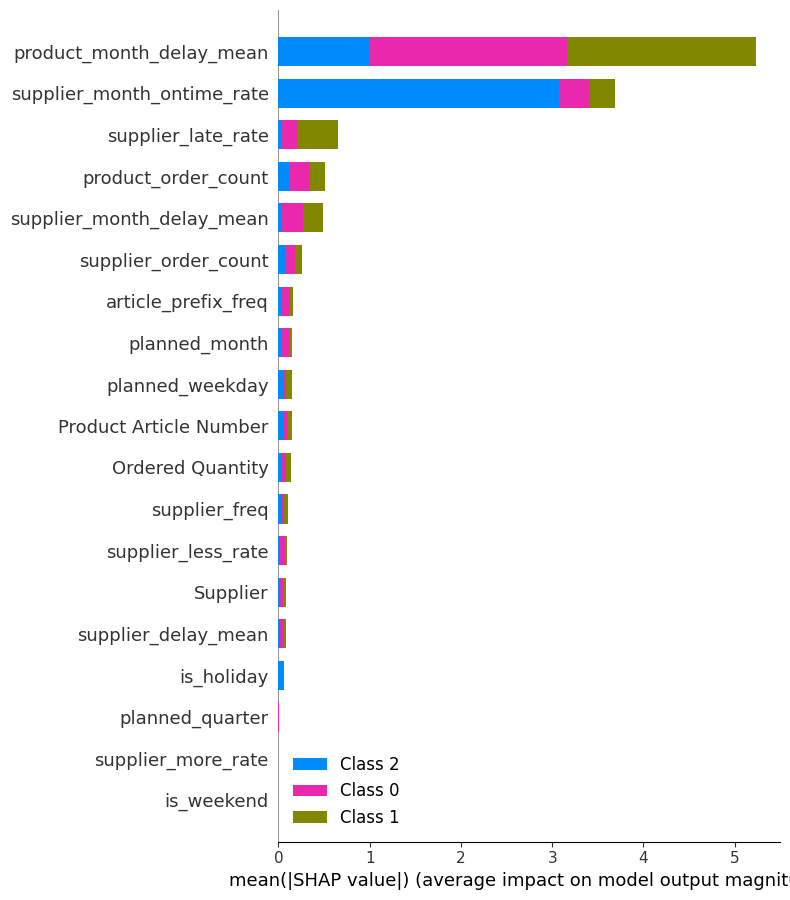

In [ ]:
# ========== SHAP Analysis: Company B Delivery Status ==========
print('\n========== SHAP Interpretative Analysis: Company B Delivery Status ==========')
explainer_b_delivery = shap.TreeExplainer(model_rf_b_delivery)
shap_values_b_delivery = explainer_b_delivery.shap_values(X_b_delivery)

shap.summary_plot(
    shap_values_b_delivery,
    X_b_delivery,
    feature_names=features_b_delivery,
    plot_type='bar',
    show=True
)
# shap.summary_plot(
#     shap_values_b_delivery,
#     X_b_delivery,
#     feature_names=features_b_delivery,
#     show=True
# )